In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Accuracy
from tensorflow.keras.applications import ResNet50V2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Define information about training images 
training_generator = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
)
# Imported training images with specific requirements
training_iterator = training_generator.flow_from_directory(
                          'train',
                          class_mode = "categorical",
                          target_size = (256,256),
                          batch_size = 32,
                          shuffle=True,
                          seed=42,
                        )

# Define information about test images 
validation_generator = ImageDataGenerator(rescale=1./255)
# Imported testimages with specific requirements
validation_iterator=validation_generator.flow_from_directory('test')


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [40]:
os.listdir('train')

['COVID19', 'NORMAL', 'PNEUMONIA']

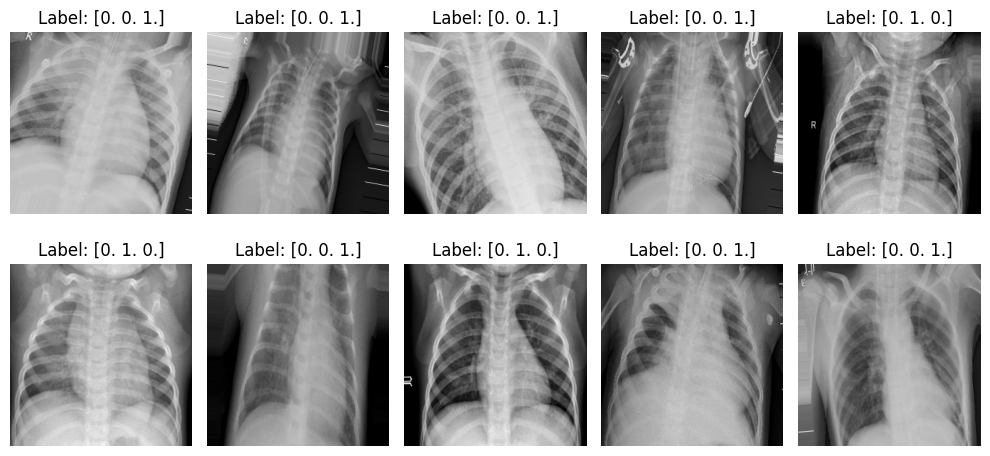

In [3]:
# Get the first batch of images and labels from the iterator
images, labels = training_iterator.next()

# Create a figure with 10 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

# Display the first 10 images in the batch
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
def plotting_accuracy(history):
    
    print("training_accuracy: ", round(history.history['categorical_accuracy'][-1]*100,4), '%')
    print("validation_accuracy: ", round(history.history['val_categorical_accuracy'][-1]*100,4), '%')
    # plotting categorical and validation accuracy over epochs
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_categorical_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid()
    ax1.legend(['train', 'validation'], loc='upper left')

    # used to keep plots from overlapping
    fig.tight_layout()
    
def plotting_loss(history):
    # plotting categorical and validation accuracy over epochs
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend(['train', 'validation'], loc='upper left')

    # used to keep plots from overlapping
    fig.tight_layout()

def evaluation_metrics(model_type):
    
    classes = ["COVID19", "NORMAL", "PNEUMONIA"]

    y_pred = model_type.predict(validation_iterator)
    y_pred = np.argmax(y_pred, axis=1)
    true_classes = validation_iterator.classes
    # class_labels = list(validation_iterator.class_indices.keys())
    
    cm = pd.DataFrame(confusion_matrix(true_classes, y_pred), columns=classes, index=classes)
    plt.figure(figsize=(9, 6))
    ax = sns.heatmap(cm, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
    ax.set_xlabel('Predicted',fontsize = 20, weight = 'bold')
    ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

    ax.set_ylabel('Actual',fontsize = 20, weight = 'bold') 
    ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
    ax.set_title('Confusion Matrix - Test Set',fontsize = 25,weight = 'bold',pad=20);
   
    print('Classification Report')
    print(classification_report(true_classes, y_pred))

In [5]:
# plotting categorical and validation accuracy over epochs
es = EarlyStopping(monitor='categorical_accuracy', mode='min', verbose=1, patience=10)

In [6]:
# Create Model
def design_model_1(training_data):

    model_1 = Sequential()
    # Input Layer
    model_1.add(Input(shape=(256,256,3)))
    # Flatten Layer
    model_1.add(Flatten())
    # Output Layer
    model_1.add(Dense(3, activation='softmax'))
    
    print("\nCompiling model...")
    model_1.compile(optimizer=Adam(learning_rate=.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])
    # Summary report 
    model_1.summary()
    
    return model_1
    
model_1 = design_model_1(training_iterator)


Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 3)                 589827    
                                                                 
Total params: 589,827
Trainable params: 589,827
Non-trainable params: 0
_________________________________________________________________


In [7]:
# training the model
history_1 = model_1.fit(
    training_iterator,
    steps_per_epoch=len(training_iterator),
    epochs=20,
    validation_data=validation_iterator,
    validation_steps=len(validation_iterator),
    callbacks=[es]
)

Epoch 1/20
161/161 [==============================] - 183s 1s/step - loss: 7.4454 - categorical_accuracy: 0.6944 - val_loss: 3.1269 - val_categorical_accuracy: 0.7648
Epoch 2/20
161/161 [==============================] - 180s 1s/step - loss: 3.1244 - categorical_accuracy: 0.7794 - val_loss: 2.0511 - val_categorical_accuracy: 0.8401
Epoch 3/20
161/161 [==============================] - 167s 1s/step - loss: 4.9817 - categorical_accuracy: 0.7461 - val_loss: 2.0227 - val_categorical_accuracy: 0.8494
Epoch 4/20
161/161 [==============================] - 168s 1s/step - loss: 4.7085 - categorical_accuracy: 0.7657 - val_loss: 2.2285 - val_categorical_accuracy: 0.8051
Epoch 5/20
161/161 [==============================] - 192s 1s/step - loss: 4.7343 - categorical_accuracy: 0.7595 - val_loss: 1.1183 - val_categorical_accuracy: 0.9146
Epoch 6/20
161/161 [==============================] - 190s 1s/step - loss: 4.3142 - categorical_accuracy: 0.7757 - val_loss: 1.8902 - val_categorical_accuracy: 0.864

training_accuracy:  78.8103 %
validation_accuracy:  86.1801 %


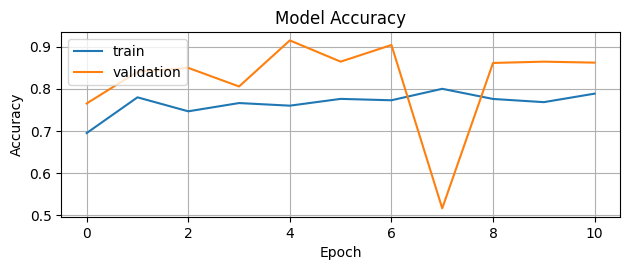

In [41]:
plotting_accuracy(history_1)

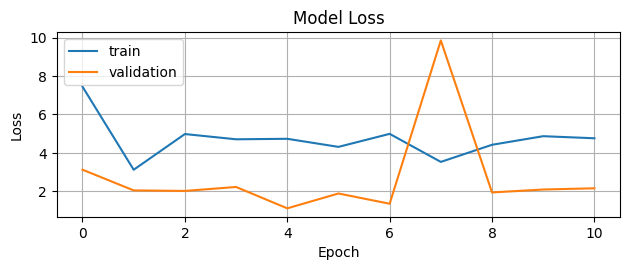

In [42]:
plotting_loss(history_1)

41/41 [==============================] - 21s 517ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.07      0.05      0.06       116
           1       0.25      0.17      0.20       317
           2       0.66      0.76      0.71       855

    accuracy                           0.55      1288
   macro avg       0.33      0.33      0.32      1288
weighted avg       0.51      0.55      0.52      1288



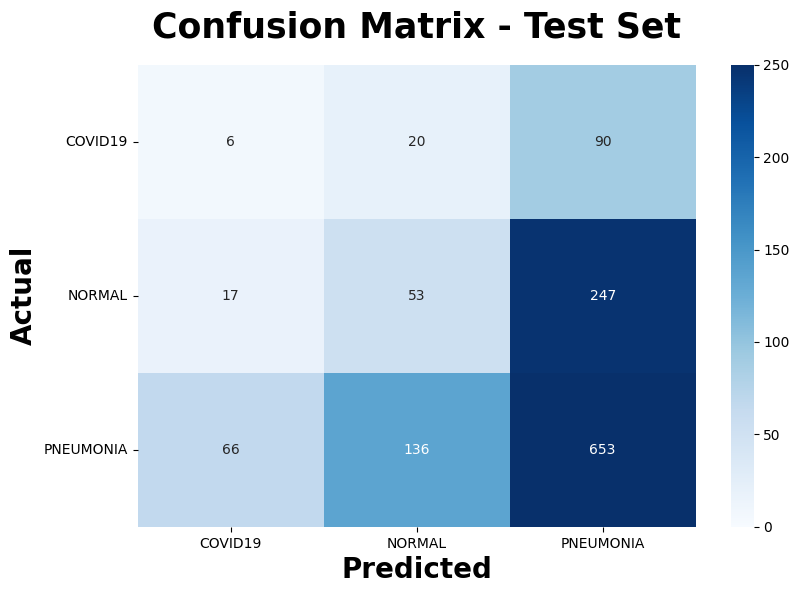

In [43]:
evaluation_metrics(model_1)

In [21]:
def design_model_2(training_data):
    # sequential model
    model_2 = Sequential()
    # add input layer with grayscale image shape
    model_2.add(Input(shape=(256, 256, 3)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model_2.add(Conv2D(3, 3, strides=1, activation="relu")) 
    model_2.add(MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model_2.add(Dropout(0.1))
    model_2.add(Conv2D(3, 3, strides=1, activation="relu")) 
    model_2.add(MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model_2.add(Dropout(0.2))

    model_2.add(Flatten())
    # output layer with softmax activation function
    model_2.add(Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model_2.compile(optimizer=Adam(learning_rate=.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])
    # summarize model
    model_2.summary()
    return model_2

# use model function
model_2 = design_model_2(training_iterator)


Compiling model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 3)       84        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 3)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 3)       84        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 3)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None

In [22]:
# training the model
history_2 = model_2.fit(
    training_iterator,
    steps_per_epoch=len(training_iterator),
    epochs=20,
    validation_data=validation_iterator,
    validation_steps=len(validation_iterator),
    callbacks=[es]
)

Epoch 1/20
161/161 [==============================] - 187s 1s/step - loss: 0.6203 - categorical_accuracy: 0.7442 - val_loss: 0.5168 - val_categorical_accuracy: 0.9037
Epoch 2/20
161/161 [==============================] - 197s 1s/step - loss: 0.4382 - categorical_accuracy: 0.8219 - val_loss: 0.4871 - val_categorical_accuracy: 0.8820
Epoch 3/20
161/161 [==============================] - 186s 1s/step - loss: 0.3935 - categorical_accuracy: 0.8445 - val_loss: 0.3469 - val_categorical_accuracy: 0.9115
Epoch 4/20
161/161 [==============================] - 184s 1s/step - loss: 0.3631 - categorical_accuracy: 0.8596 - val_loss: 0.3099 - val_categorical_accuracy: 0.9014
Epoch 5/20
161/161 [==============================] - 186s 1s/step - loss: 0.3653 - categorical_accuracy: 0.8499 - val_loss: 0.3161 - val_categorical_accuracy: 0.8929
Epoch 6/20
161/161 [==============================] - 184s 1s/step - loss: 0.3436 - categorical_accuracy: 0.8618 - val_loss: 0.2554 - val_categorical_accuracy: 0.913

training_accuracy:  88.1998 %
validation_accuracy:  92.3913 %


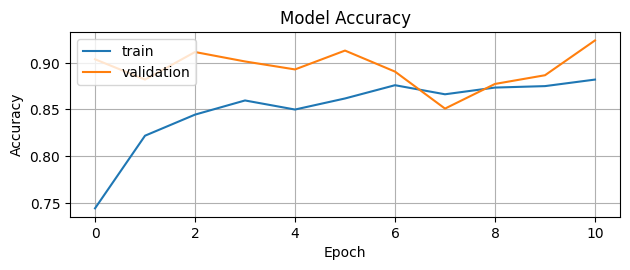

In [23]:
plotting_accuracy(history_2)

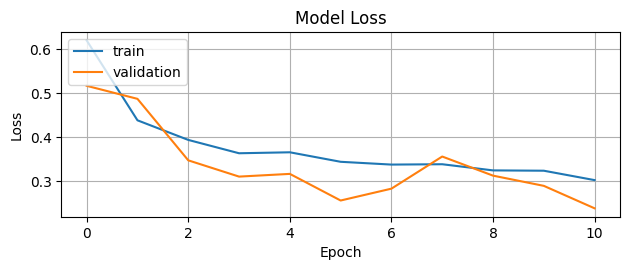

In [24]:
plotting_loss(history_2)

41/41 [==============================] - 22s 540ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.10      0.09      0.09       116
           1       0.28      0.27      0.28       317
           2       0.67      0.70      0.68       855

    accuracy                           0.54      1288
   macro avg       0.35      0.35      0.35      1288
weighted avg       0.52      0.54      0.53      1288



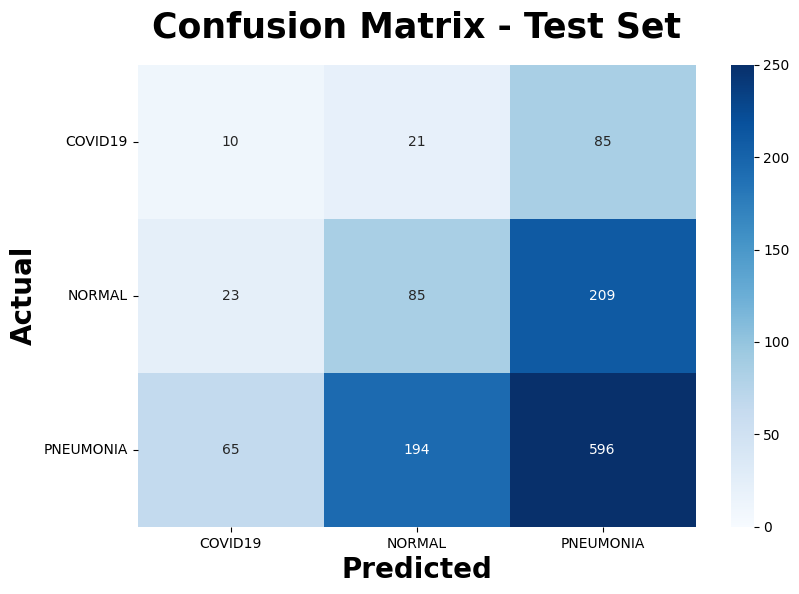

In [25]:
evaluation_metrics(model_2)

In [35]:
def design_model_3(training_data):
    
    base_model =ResNet50V2(include_top=False,weights='imagenet',input_shape=(256, 256, 3))
    
        # Freeze the weights of the base model so that they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False
    
    # sequential model
    model_3 = Sequential()
    model_3.add(base_model)
    model_3.add(GlobalAveragePooling2D())
    model_3.add(Dense(256, activation='relu'))
    model_3.add(Dropout(0.2))
    model_3.add(Dense(3, activation='softmax'))

  
    print("\nCompiling model...")
    model_3.compile(optimizer=Adam(learning_rate=.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()],)
    # summarize model
    model_3.summary()
    return model_3

# use model function
model_3 = design_model_3(training_iterator)


Compiling model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 3)                 771       
                                                                 
Total params: 24,090,115
Trainable params: 525,315
Non-trainable params: 23,564,800
________________

In [36]:
history_3 = model_3.fit(
    training_iterator,
    steps_per_epoch=len(training_iterator),
    epochs=20,
    validation_data=validation_iterator,
    validation_steps=len(validation_iterator),
    callbacks=[es]
)

Epoch 1/20
161/161 [==============================] - 479s 3s/step - loss: 0.2723 - categorical_accuracy: 0.8946 - val_loss: 0.2895 - val_categorical_accuracy: 0.8890
Epoch 2/20
161/161 [==============================] - 481s 3s/step - loss: 0.1766 - categorical_accuracy: 0.9360 - val_loss: 0.1807 - val_categorical_accuracy: 0.9293
Epoch 3/20
161/161 [==============================] - 481s 3s/step - loss: 0.1555 - categorical_accuracy: 0.9473 - val_loss: 0.1735 - val_categorical_accuracy: 0.9309
Epoch 4/20
161/161 [==============================] - 481s 3s/step - loss: 0.1621 - categorical_accuracy: 0.9442 - val_loss: 0.2050 - val_categorical_accuracy: 0.9239
Epoch 5/20
161/161 [==============================] - 499s 3s/step - loss: 0.1397 - categorical_accuracy: 0.9493 - val_loss: 0.1855 - val_categorical_accuracy: 0.9231
Epoch 6/20
161/161 [==============================] - 500s 3s/step - loss: 0.1272 - categorical_accuracy: 0.9518 - val_loss: 0.1236 - val_categorical_accuracy: 0.957

training_accuracy:  95.3149 %
validation_accuracy:  92.0031 %


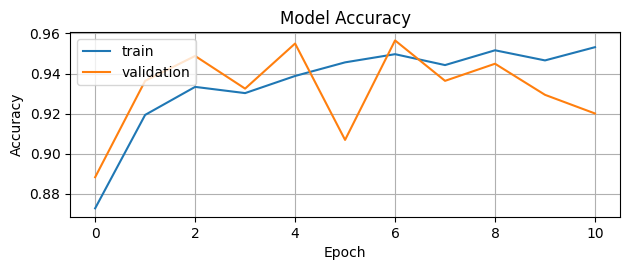

In [30]:
plotting_accuracy(history_3)

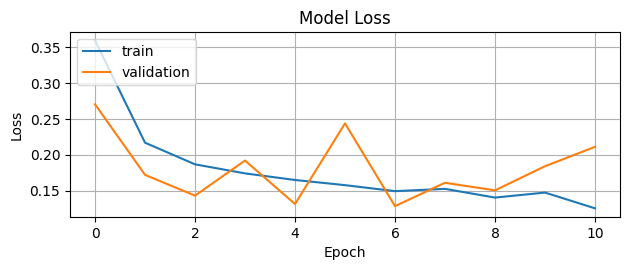

In [31]:
plotting_loss(history_3)

41/41 [==============================] - 82s 2s/step
Classification Report
              precision    recall  f1-score   support

           0       0.06      0.06      0.06       116
           1       0.24      0.30      0.27       317
           2       0.67      0.61      0.64       855

    accuracy                           0.49      1288
   macro avg       0.32      0.32      0.32      1288
weighted avg       0.51      0.49      0.50      1288



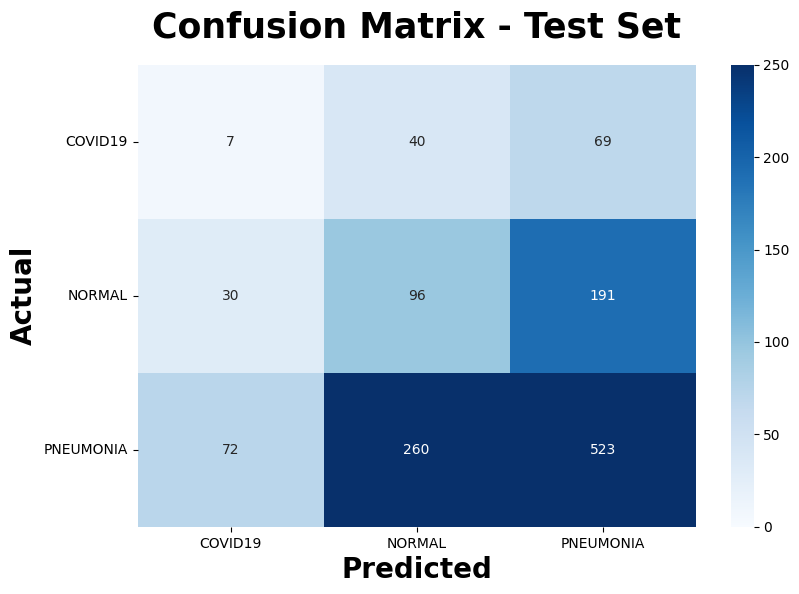

In [32]:
evaluation_metrics(model_3)

In [33]:
model_1.save('models_1_fol','model_1.h5')
model_2.save('models_2_fol','model_2.h5')
model_3.save('models_3_fol','model_3.h5')

INFO:tensorflow:Assets written to: models_1_fol\assets


INFO:tensorflow:Assets written to: models_1_fol\assets


INFO:tensorflow:Assets written to: models_2_fol\assets


INFO:tensorflow:Assets written to: models_2_fol\assets


INFO:tensorflow:Assets written to: models_3_fol\assets


INFO:tensorflow:Assets written to: models_3_fol\assets
